# Arxiv Title Generation

Последнее задание курса "Нейронные сеит и обработка текста" на степике https://stepik.org/lesson/261085/step/1

В задаче предлагается по предложенному фрагменту статьи сгенерировать заголовок.
В качестве решения я использую предобученную модель BERT в качестве автокодировщика (одна и та же модель для энкодера и декодера). Эту модель я дообучаю на имеющихся данных.

Пара замечаний:
1. Из России оказалось проблемным купить себе подписку на colab pro, либо арендовать сервер с GPU на google cloud platform (другие решения я пока не рассматривал). Поэтому некоторые параметры обучения (максимальная длина последовательности, размер батча, количество эпох) было обусловлено не оптимальным выбором, а ограничениями пратформы colab.

2. Оказалось, что часть статей из тестовых данных встречается в тренировочных. Чтобы не делать лишних предсказаний, в качестве тестового файла используется файл sample.csv, с уже проставленными некоторыми заголовками. В этом ноутбуке работа с дубликатами не показана.

Результат: обучив всего одну эпоху модели (больше не позволяла платформа по времени сессии) я получил f1-score около 52 % в соответсвующем соревновании на kaggle https://www.kaggle.com/c/title-generation/leaderboard

In [ ]:
!pip install transformers

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import EncoderDecoderModel, AdamW
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import nltk
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 1. Data processing

In [4]:
data_path = 'drive/MyDrive/Colab Notebooks/stepik_data/'

In [5]:
# processed_data - train, очищенный от дубликатов
df = pd.read_csv(data_path + 'processed_data.csv')
df

,abstract,title
0,we consider the problem of utility maximizatio...,on optimal investment with processes of long o...
1,in this paper we provide an explicit formula f...,boolean complexes for ferrers graphs
2,"kinesin-5, also known as eg5 in vertebrates is...",relative velocity of sliding of microtubules b...
3,we discuss the transition paths in a coupled b...,bifurcation of transition paths induced by cou...
4,two types of room temperature detectors of ter...,all-electric detectors of the polarization sta...
...,...,...
105598,the epidemic threshold is probably the most st...,epidemic threshold in pairwise models for clus...
105599,we develop a model characterizing all possible...,characterization of knots and links arising fr...
105600,a combined technique of interference alignment...,achievable degrees of freedom for closed-form ...
105601,the correspondence between unmixed bipartite g...,unmixed bipartite graphs and sublattices of th...


In [6]:
df['abstract'] = df.abstract.apply(lambda x: "[CLS] " + x + " [SEP]")
df['title'] = df.title.apply(lambda x: "[CLS] " + x + " [SEP]")

In [7]:
train_abstract, test_abstract, train_title, test_title = train_test_split(df.abstract, df.title, test_size=0.2)
print(len(train_abstract), len(test_abstract))

84482 21121


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [9]:
%%time
tokenized_texts = [tokenizer.tokenize(sent) for sent in train_abstract]
tokenized_titles = [tokenizer.tokenize(sent) for sent in train_title]
print(tokenized_titles[0])

['[CLS]', 'bf', '##k', '##l', 'at', 'n', '##nl', '##o', '[SEP]']
CPU times: user 6min 25s, sys: 2.41 s, total: 6min 27s
Wall time: 6min 27s


In [10]:
text_lengths = list(map(lambda x: len(x), tokenized_texts))
np.median(text_lengths), np.max(text_lengths)

(180.0, 1096)

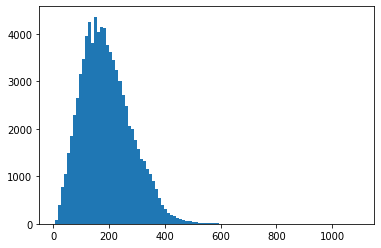

In [11]:
plt.hist(text_lengths, bins=100)
plt.show()

In [12]:
title_lengths = list(map(lambda x: len(x), tokenized_titles))
np.median(title_lengths), np.max(title_lengths)

(15.0, 103)

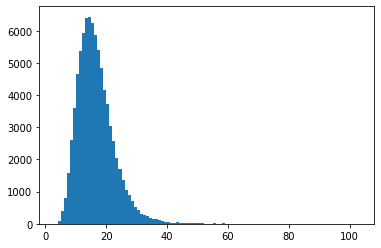

In [13]:
plt.hist(title_lengths, bins=100)
plt.show()

Максимальную длину последовательности текстов статей стоит выбрать больше 150

In [14]:
encoder_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
encoder_input_ids = pad_sequences(
    encoder_input_ids,
    maxlen=150,
    dtype="long",
    truncating="post",
    padding="post"
)

decoder_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_titles]
decoder_input_ids = pad_sequences(
    decoder_input_ids,
    maxlen=30,
    dtype="long",
    truncating="post",
    padding="post"
)

encoder_attention_masks = [[float(i>0) for i in seq] for seq in encoder_input_ids]
decoder_attention_masks = [[float(i>0) for i in seq] for seq in decoder_input_ids]

In [15]:
train_enc_inputs, validation_enc_inputs, train_dec_inputs, validation_dec_inputs = train_test_split(
    encoder_input_ids, decoder_input_ids, 
    random_state=42,
    test_size=0.1
)

train_enc_masks, validation_enc_masks, train_dec_masks, validation_dec_masks = train_test_split(
    encoder_attention_masks, decoder_attention_masks,
    random_state=42,
    test_size=0.1
)

In [16]:
train_enc_inputs = torch.tensor(train_enc_inputs)
train_dec_inputs = torch.tensor(train_dec_inputs)
train_enc_masks = torch.tensor(train_enc_masks)
train_dec_masks = torch.tensor(train_dec_masks)

In [17]:
validation_enc_inputs = torch.tensor(validation_enc_inputs)
validation_dec_inputs = torch.tensor(validation_dec_inputs)
validation_enc_masks = torch.tensor(validation_enc_masks)
validation_dec_masks = torch.tensor(validation_dec_masks)

In [18]:
train_data = TensorDataset(train_enc_inputs, train_dec_inputs, train_enc_masks, train_dec_masks)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=16
)

In [19]:
validation_data = TensorDataset(validation_enc_inputs, validation_dec_inputs, validation_enc_masks, validation_dec_masks)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=16
)

## 2. Model training

In [ ]:
model = EncoderDecoderModel.from_encoder_decoder_pretrained('bert-base-uncased', 'bert-base-uncased')

In [21]:
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

In [ ]:
model.cuda()

Обучаемые параметры взяты по рекомендации из курса

In [23]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

In [24]:
## custom loss usage

criterion = nn.NLLLoss(ignore_index=tokenizer.pad_token_id)

def compute_loss(predictions, targets):
    predictions = predictions[:, :-1, :].contiguous()
    targets = targets[:, 1:]

    rearranged_output = predictions.view(predictions.shape[0]*predictions.shape[1], -1)
    rearranged_target = targets.contiguous().view(-1)

    loss = criterion(rearranged_output, rearranged_target)

    return loss

In [25]:
def train(model, iterator, optimizer):
    
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        
        optimizer.zero_grad()
        
        batch = tuple(t.to(device) for t in batch)
        enc_ids, dec_ids, enc_mask, dec_mask = batch
        lm_labels = dec_ids.clone()
        
        outputs = model(
            input_ids=enc_ids, 
            attention_mask=enc_mask, 
            decoder_input_ids=dec_ids,
            decoder_attention_mask=dec_mask,
            labels=lm_labels   
        )
        
        prediction_scores = outputs.logits
        predictions = F.log_softmax(prediction_scores, dim=2)
        loss = compute_loss(predictions, dec_ids)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        epoch_loss += loss.item()

    print("Mean epoch loss:", (epoch_loss / len(iterator)))

In [26]:
def evaluate(model, iterator):
    
    model.eval()
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        
        optimizer.zero_grad()
        
        batch = tuple(t.to(device) for t in batch)
        enc_ids, dec_ids, enc_mask, dec_mask = batch
        lm_labels = dec_ids.clone()
        
        with torch.no_grad():
            outputs = model(
                input_ids=enc_ids, 
                attention_mask=enc_mask, 
                decoder_input_ids=dec_ids,
                decoder_attention_mask=dec_mask,
                labels=lm_labels   
            )
            
            prediction_scores = outputs.logits
            predictions = F.log_softmax(prediction_scores, dim=2)
            loss = compute_loss(predictions, dec_ids)
            epoch_loss += loss.item()

    print("Mean epoch loss:", (epoch_loss / len(iterator)))

In [27]:
torch.cuda.empty_cache()

In [28]:
for epoch in range(1):
    print('Epoch', epoch+1)
    train(model, train_dataloader, optimizer)
    evaluate(model, validation_dataloader)

Epoch 1


/usr/local/lib/python3.7/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:524: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Mean epoch loss: 4.385681864840594
Mean epoch loss: 3.5504379889915483


In [29]:
model.save_pretrained(data_path + 'bert2bert')

## 3. Model evaluation

Предобработка включает все шаги процессинга, но уже для тестовых данных. Генерация будет осуществляться встроенными методами модели.

In [30]:
%%time
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_abstract]
tokenized_titles = [tokenizer.tokenize(sent) for sent in test_title]

CPU times: user 1min 37s, sys: 1.41 s, total: 1min 38s
Wall time: 1min 39s


In [31]:
test_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
test_input_ids = pad_sequences(
    test_input_ids,
    maxlen=150,
    dtype="long",
    truncating="post",
    padding="post"
)

In [32]:
test_input_ids = torch.tensor(test_input_ids)

Ниже пример сгенерированного заголовка и реальный тестовый заголовок

In [33]:
generated_ids = model.generate(test_input_ids[0].unsqueeze(0).to(device))
generated_text = tokenizer.convert_ids_to_tokens(generated_ids[0])
generated_text

['[CLS]',
 'on',
 'the',
 'semi',
 '##group',
 '##s',
 'of',
 'the',
 'semi',
 '##group',
 '##s',
 'of',
 'the',
 'semi',
 '##group',
 '##s',
 '[SEP]',
 'on',
 'the',
 'semi']

In [34]:
tokenized_titles[0]

['[CLS]',
 'functions',
 'with',
 'support',
 'in',
 'a',
 'lac',
 '##una',
 '##ry',
 'system',
 'of',
 'intervals',
 'and',
 'cyclic',
 '##ity',
 'for',
 'the',
 'semi',
 '-',
 'group',
 'of',
 'left',
 'translations',
 '[SEP]']

Оценка модели производится так же, как и в курсовом бейслайне

In [ ]:
n_gram_weights = [0.3334, 0.3333, 0.3333]
macro_bleu = 0

for input_id, target_text in tqdm(zip(test_input_ids, tokenized_titles), total=len(test_title)):
    generated_ids = model.generate(input_id.unsqueeze(0).to(device))
    generated_text = tokenizer.convert_ids_to_tokens(generated_ids[0])
    bleu_score = nltk.translate.bleu_score.sentence_bleu(
        target_text,
        generated_text,
        weights = n_gram_weights
    )    
    macro_bleu += bleu_score
macro_bleu /= len(test_titlle)
macro_bleu

In [36]:
macro_bleu

59.85722808690963

## 4. Submission making

In [38]:
## в sample.csv проставлены тайтлы тех документов, которые были в тренировочных данных
test_data = pd.read_csv(data_path + 'sample.csv')
test_data

,abstract,title
0,Most sequence transformation models use recurr...,NaN
1,The doc2vec approach was introduced as an exte...,NaN
2,LSTM models can vary greatly depending on sequ...,NaN
3,A joint learning process of alignment and tran...,NaN
4,Current unsupervised image-to-image translatio...,NaN
...,...,...
995,subsystem codes are the most versatile class o...,NaN
996,we study dirac-harmonic maps from degenerating...,NaN
997,in this note we study kloosterman sums twisted...,NaN
998,we obtain the rate of growth of long strange s...,"long strange segments, ruin probabilities and ..."


In [41]:
test_texts = test_data[test_data.title.isna()].abstract.apply(lambda x: "[CLS] " + x + " [SEP]")
test_text_tokenized = [tokenizer.tokenize(sent) for sent in test_texts]

In [42]:
test_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in test_text_tokenized]
test_input_ids = pad_sequences(
    test_input_ids,
    maxlen=150,
    dtype="long",
    truncating="post",
    padding="post"
)

In [43]:
test_input_ids = torch.tensor(test_input_ids)

Дополнительно я очищаю тексты от служебных токенов и повторений.

In [63]:
def clear_generated(generated_text):
    prev_token = ''
    result = []
    for token in generated_text.split():
        if token in (['[CLS]', '[SEP]', '[PAD]']):
            continue
        elif token == prev_token:
            continue
        else:
            prev_token = token
            result.append(token)
    return result

In [64]:
for test_id, idx in tqdm(zip(test_input_ids, test_texts.index), total=len(test_texts)):
    generated_ids = model.generate(test_id.unsqueeze(0).to(device))
    generated_text = tokenizer.convert_ids_to_tokens(generated_ids[0])
    generated_text = tokenizer.convert_tokens_to_string(generated_text)
    generated_text = clear_generated(generated_text)
    test_data.loc[idx, 'title'] = ' '.join(generated_text)

  0%|          | 0/569 [00:00<?, ?it/s]

In [65]:
test_data

,abstract,title
0,Most sequence transformation models use recurr...,a deep learning approach to recurrent neural n...
1,The doc2vec approach was introduced as an exte...,a new approach to the emc2c22veveveveveveveve
2,LSTM models can vary greatly depending on sequ...,a multiplicative lstmm approach to lstm search...
3,A joint learning process of alignment and tran...,a new approach to understanding the attention ...
4,Current unsupervised image-to-image translatio...,unsupervised image translation unsuperpervised
...,...,...
995,subsystem codes are the most versatile class o...,subsymmetric subsymme
996,we study dirac-harmonic maps from degenerating...,dirichlet - type dirichlet maps on the dir dir...
997,in this note we study kloosterman sums twisted...,a note on kronecker sums counting on k \ ' e $...
998,we obtain the rate of growth of long strange s...,"long strange segments, ruin probabilities and ..."


In [66]:
test_data.loc[1, 'title']

'a new approach to the emc2c22veveveveveveveve'

In [67]:
test_data.to_csv(data_path + 'my_test.csv', index=False)